In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm

# add the directory where fixed_income_derivatives.py is located to the system path
sys.path.append(os.path.abspath("../../Files"))

# import own module
import fixed_income_derivatives_E2024 as fid

%load_ext autoreload
%autoreload 2

## Problem 2: Fitting CIR to the Yield Curve

### Setup

In [2]:
r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
T_max = 10 # years
alpha = 0.5 # timing between payments
M = int(T_max/alpha) + 1 # number of payments (periods +1 as range is exclusive)
T = np.array([i*alpha for i in range(0,M)])

### (a)

In [3]:
p = fid.zcb_price_cir(r0, a, b, sigma, T)
R = fid.spot_rate_cir(r0, a, b, sigma, T)
f = fid.forward_rate_cir(r0, a, b, sigma, T)

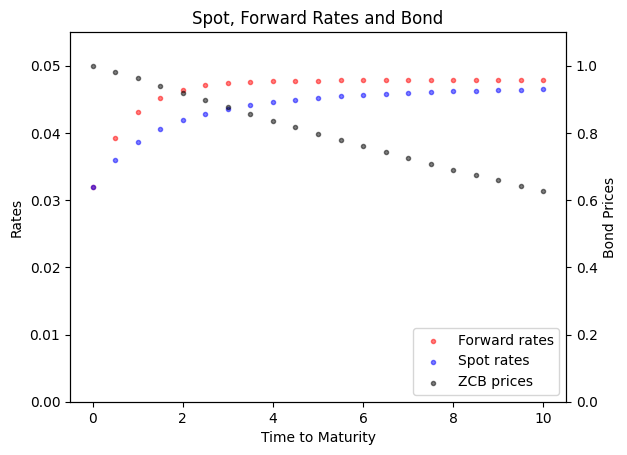

In [4]:
# Plot spot and forward rates
fig, ax1 = plt.subplots()

scatter1 = ax1.scatter(T, f, label='Forward rates', alpha=0.5, marker='.', color='red')
scatter2 = ax1.scatter(T, R, label='Spot rates', alpha=0.5, marker='.', color='blue')
ax1.set_ylim([0, 0.055])
ax1.set_xlabel('Time to Maturity')
ax1.set_ylabel('Rates')

# Add bond prices to the plot on the right axis
ax2 = ax1.twinx()
scatter3 = ax2.scatter(T, p, label='ZCB prices', alpha=0.5, marker='.', color='black')
ax2.set_ylim([0, 1.1])
ax2.set_ylabel('Bond Prices')

# Combine legends
scatters = [scatter1, scatter2, scatter3]
labels = [scatter.get_label() for scatter in scatters]
ax1.legend(scatters, labels, loc='lower right')

plt.title('Spot, Forward Rates and Bond')
plt.show()
plt.close()

### (b)

In [5]:
param_0 = 0.03, 0.5, 0.04, 0.08
result = minimize(fid.fit_cir_obj,param_0, method='nelder-mead', args=(R, T), options={'xatol':1e-7, 'disp':True})
print(f'Parameter from the fit:\n{result.x}\nSSE of the fit:\n{result.fun}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 190
         Function evaluations: 341
Parameter from the fit:
[0.03199967 1.1966947  0.04805028 0.11381587]
SSE of the fit:
7.13408384994831e-13


### (c)

In [6]:
param_0 = 0.03, 0.5, 0.04
result = minimize(fid.fit_cir_no_sigma_obj,param_0, method='nelder-mead', args=(sigma,R, T), options={'xatol':1e-7, 'disp':True})
print(f'Parameter from the fit:\n{result.x}\nSSE of the fit:\n{result.fun}')

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 133
         Function evaluations: 238
Parameter from the fit:
[0.032      1.19999993 0.048     ]
SSE of the fit:
2.152995823905639e-19


## Problem 3: Interest Rate Swap

### (a)

In [7]:
idx_n, idx_N = 0, 20 # half year fixings for 10 years

# # inefficient way to calculate S_swap
# S_swap = 0
# for idx in range(idx_n+1, idx_N+1):
#     S_swap += alpha*p[idx]

S_swap = np.sum(alpha*p[idx_n+1:idx_N+1]) # computationally more efficient

R_swap = (p[idx_n] - p[idx_N])/S_swap

print(f'Par swap rate:\n{R_swap}')

Par swap rate:
0.046800678748095556


### (b)

In [8]:
# function to loop over
def swap_fct(idx_n,idx_N,alpha,p):
    S_swap = np.sum(alpha*p[idx_n+1:idx_N+1])
    R_swap = (p[idx_n] - p[idx_N])/S_swap
    return R_swap, S_swap

In [9]:
R_swap_plot = np.zeros(M)
idx_N_plot = np.array([i for i in range(2,M)])  
for idx_N in idx_N_plot:
    R_swap_plot[idx_N] = swap_fct(idx_n,idx_N,alpha,p)[0]


## Problem 4: Simulating the short rate in the CIR model

### (b)

In [10]:
np.random.seed(2024)
M_simul, T_simul = 1000, 10
size_ci = 0.95
r_simul = fid.simul_cir(r0, a, b, sigma, M_simul, T_simul, method='exact')

### (c)

In [11]:
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci)

### (d)

In [12]:
lb_sd, ub_sd = fid.ci_cir(r0,a,b,sigma,100,size_ci)

### Plot

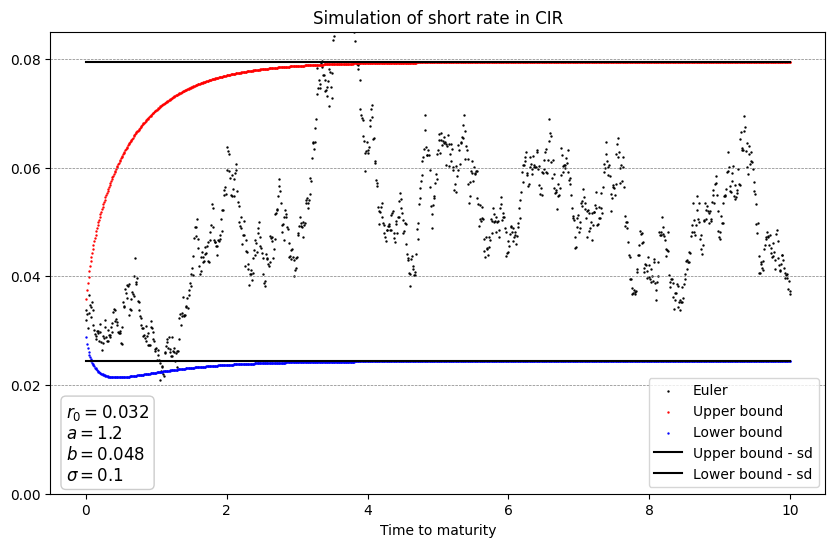

In [13]:
# plot the simulation
plt.figure(figsize=(10, 6))
plt.scatter(t_simul, r_simul, label='Euler', color='black', marker='.', s=2)
plt.scatter(t_simul, ub, label='Upper bound', color='red', marker='.', s=2)
plt.scatter(t_simul, lb, label='Lower bound', color='blue', marker='.', s=2)
plt.plot(t_simul, ub_sd * np.ones(t_simul.shape[0]), label='Upper bound - sd', color='black')
plt.plot(t_simul, lb_sd * np.ones(t_simul.shape[0]), label='Lower bound - sd', color='black')

plt.xlabel('Time to maturity')
plt.title('Simulation of short rate in CIR')
plt.ylim(bottom=0, top=0.085)

# Add horizontal lines at each tick mark
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(0.02))
for tick in ax.get_yticks():
    ax.axhline(y=tick, color='gray', linestyle='--', linewidth=0.5)

plt.legend(loc='lower right')

textstr = f'$r_0={r0}$\n$a={a}$\n$b={b}$\n$\\sigma={sigma}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.2)
plt.text(0.02, 0.02, textstr, transform=ax.transAxes, fontsize=12,
         verticalalignment='bottom', bbox=props)

plt.show()

## Problem 5: Pricing an Interest Rate Cap in the CIR Model

### (c)

In [14]:
np.random.seed(2024)
T_cap_begin, T_cap_end = 0.5, 5
strike = 0.045
idx_cap_begin, idx_cap_end = int(T_cap_begin/alpha), int(T_cap_end/alpha)
price_caplet = np.zeros([idx_cap_end+1])
M_simul_cap, N_simul = 1000, 1000
chi = np.zeros([idx_cap_end-1, N_simul])
r_simul_cap = np.zeros([M_simul_cap+1])
for i in range(0,N_simul):
    r_simul_cap = fid.simul_cir(r0, a, b, sigma, M_simul_cap, T_cap_end, method='exact')
    for idx in range(idx_cap_begin, idx_cap_end):
        idx_r_announcement = idx * int((alpha * M_simul_cap)/T_cap_end)
        idx_payment = (idx+1) * int((alpha * M_simul_cap)/T_cap_end)
        p_cap = fid.zcb_price_cir(r_simul_cap[idx_r_announcement], a, b, sigma, alpha)
        delta = (idx + 1) * alpha / idx_payment
        # print(f'idx: {idx}, idx_r_announcement: {idx_r_announcement}, idx_payment: {idx_payment}, p_cap: {p_cap}, delta: {delta}')
        chi[idx-1,i] = np.exp(-np.sum(r_simul_cap[0:idx_payment]) * delta) * (1 + alpha * strike) * np.max(1/(1+alpha*strike)-p_cap,0)

for idx in range(idx_cap_begin+1, idx_cap_end+1):
    price_caplet[idx] = np.mean(chi[idx-2,:])

print(f'Price caplet:\n{price_caplet*10000,np.sum(price_caplet)}')


Price caplet:
(array([  0.        ,   0.        , -16.76533602,   1.03808931,
         7.64170261,  10.95037976,  11.04265213,  12.25497194,
        12.90413748,  12.68545013,  13.23859122]), 0.006499063855540452)


### (d)

In [15]:
np.random.seed(2024)
idx_n_swaption, idx_N_swaption = 4, 10
M_simul_swaption, N_simul_swapltion, T_simul_swaption = 1000, 2000, T[idx_n_swaption]
chi, price_swaption_simul = np.zeros([N_simul_swapltion]), np.zeros([N_simul_swapltion])
T_swaption = np.array([T[i] - T[idx_n_swaption] for i in range(idx_n_swaption, idx_N_swaption+1)])
R_swaption = 0.045
for i in range(0,N_simul_swapltion):
    r_simul_swaption = fid.simul_cir(r0, a, b, sigma, M_simul_swaption, T_simul_swaption, method='exact')
    p_swaption = fid.zcb_price_cir(r_simul_swaption[-1], a, b, sigma, T_swaption)
    R_swap, S_swap = swap_fct(0, idx_N_swaption-idx_n_swaption, alpha, p_swaption)
    chi[i] = np.max(R_swap - R_swaption,0) * S_swap
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*np.sum(r_simul_swaption)) * chi[i]

price_swaption = np.mean(price_swaption_simul)

print(f'Price swaption:\n{price_swaption*10000}')


Price swaption:
78.82236948623185
